<a href="https://colab.research.google.com/github/comparativechrono/covid-chronotyping/blob/main/Covid_chronotype_association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronotype enrichment in 100K Covid-19 frequent release data using Fishers exact test

## Comparative chronomics group 
### August 2020

# 0. Set up the working environment

Before we do any work we need to install and load the required packages. For this analysis we will be using a range of libraries which are part of tidyverse. For simplicities sake I always just load tidyverse to begin with.

In [2]:
# Install tidyverse if you have not got it installed

install.packages("tidyverse")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
# Run tidyverse library

library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# 1. Import data

The following comparisons need to be made:

1A - Covid whole	vs 	100K reference

2A - Covid positive vs 	100K reference

3A - Covid positive vs 	Covid negative

4A - Covid positive acute vs Covid positive nonacute

The datasets are named with the letter and number combinations shown here.

Links to files: 

1A - https://www.dropbox.com/s/b5irfxk71xvgljj/1A.csv?dl=1

2A - https://www.dropbox.com/s/nzw22w9gjhkn0hr/2A.csv?dl=1

3A - https://www.dropbox.com/s/vu460c8c7u70h2k/3A.csv?dl=1

4A - https://www.dropbox.com/s/wpipljhgibhsnph/4A.csv?dl=1

First we will need to import our dataset for the analysis. I am doing this from a link so this can be run without additional files. The files are currently stored in my DropBox account - the files are saved as csv files. You will need to replace the url, shown in the example below, for each dataset. These files are taken from the release in June 2020 at the end of the first wave of the pandemic, and therefore have a greater chance of representing genetic differences. As of Dec 2021 1 in 6 people have officially had Covid-19, making the earlier datasets more likely to have greater power at picking genetic associations up.

In [12]:
exp1A <- read.csv("https://www.dropbox.com/s/b5irfxk71xvgljj/1A.csv?dl=1", header = TRUE)

In [13]:
head(exp1A)

,marker,covid_whole_Alt,covid_whole_Ref,X100K_Alt,X100K_Ref
,<chr>,<int>,<int>,<int>,<int>
1,rs909757,1015,2707,56102,95796
2,rs61773390,541,3181,27985,123913
3,rs12065331,907,2815,48205,103693
4,rs17448682,655,3067,33942,117956
5,rs10917513,1758,1964,93236,58662
6,rs10916892,1063,2659,54583,97315


The data you have imported are as a csv file. This file is in matrix format. Each row is a seperate 2x2 contingency table, in the format i,j. This is matrix nomenclature, essentially it means that each row needs to be split into a matrix to make a 2x2 table with the numbers first filling rows in the first columns, and then the second. This is shown below with an example from the first line of file 1A.

In [24]:
test <- c(1015,2707,56102,95796)
matrix(unlist(test), nrow = 2)

1015,56102
2707,95796


So in our contingency table the columns represent people who have taken tests in the 100K, versus those who had not, and the rows represent alleles.

# 2. An example enrichment analysis

To analyse this data there are a number of approaches, the simplest is to use Fisher's exact test.

In [51]:
# Make list from csv file and run Fishers
analysis  <- read.csv("https://www.dropbox.com/s/vu460c8c7u70h2k/3A.csv?dl=1", header = TRUE) %>% 
  setNames(c("group", "V1","V2","V3","V4")) %>% 
  nest(-group) %>% 
  mutate(matrix = map(data, ~matrix(unlist(.x), nrow = 2))) %>% 
  mutate(fisher = map(matrix, ~fisher.test(.x))) %>% 
  mutate(stats = map(fisher, ~broom::glance(.x)))


Warning message:
“All elements of `...` must be named.
Did you want `data = c(V1, V2, V3, V4)`?”


In [52]:
# Extract p value and odds ratio and write out to results file
analysis %>% 
  unnest(stats) %>%
  select(group, p.value, odds = estimate) %>% 
  write.csv("Fishers_results.csv")

## You can now open the file Fishers_results.csv in excel ##

# 3. Make some graphs

In [53]:
# If you prefer to work in R then this is the following type of analysis to do:
results <- analysis %>% 
  unnest(stats) %>%
  select(group, p.value, odds = estimate) 
  

In [54]:
head(results)

group,p.value,odds
<chr>,<dbl>,<dbl>
rs909757,8.147949e-19,0.4278476
rs61773390,1.173420e-06,0.5550871
rs12065331,1.636923e-14,0.4675953
rs17448682,4.717754e-16,0.3847098
rs10917513,3.126457e-37,0.3552899
rs10916892,5.713054e-18,0.4459365


There are a number of analyses that can be performed. The first is to graph the data in different ways, and see what it is telling us.

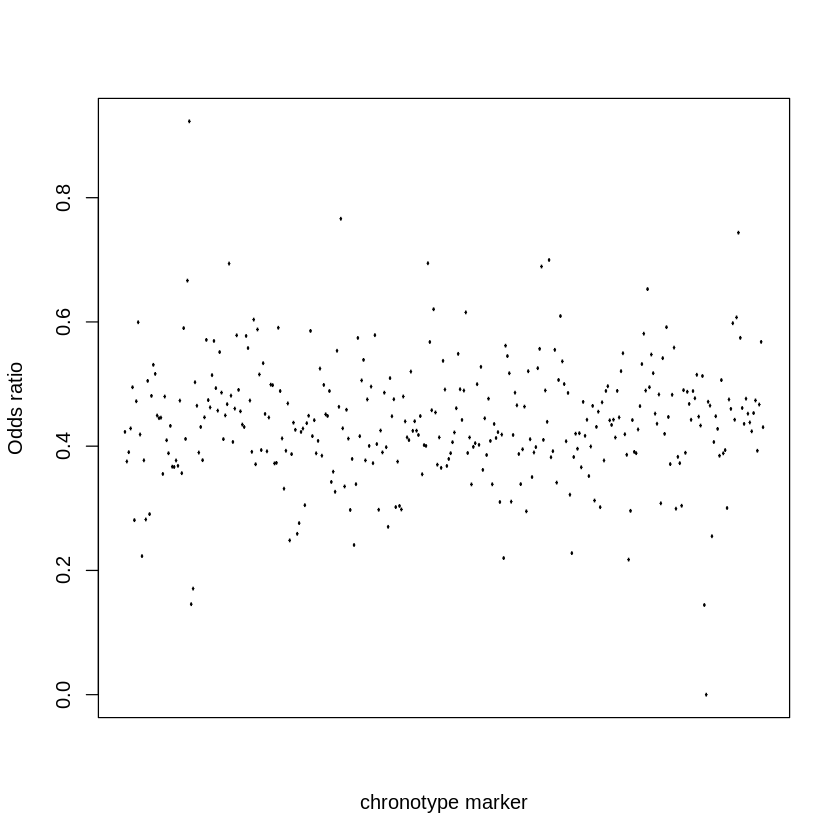

In [59]:
## make a plot of the odds ratio
plot(as.factor(results$group), results$odds, type = "p", xaxt='n', xlab = "chronotype marker", ylab = "Odds ratio", lwd = 1)


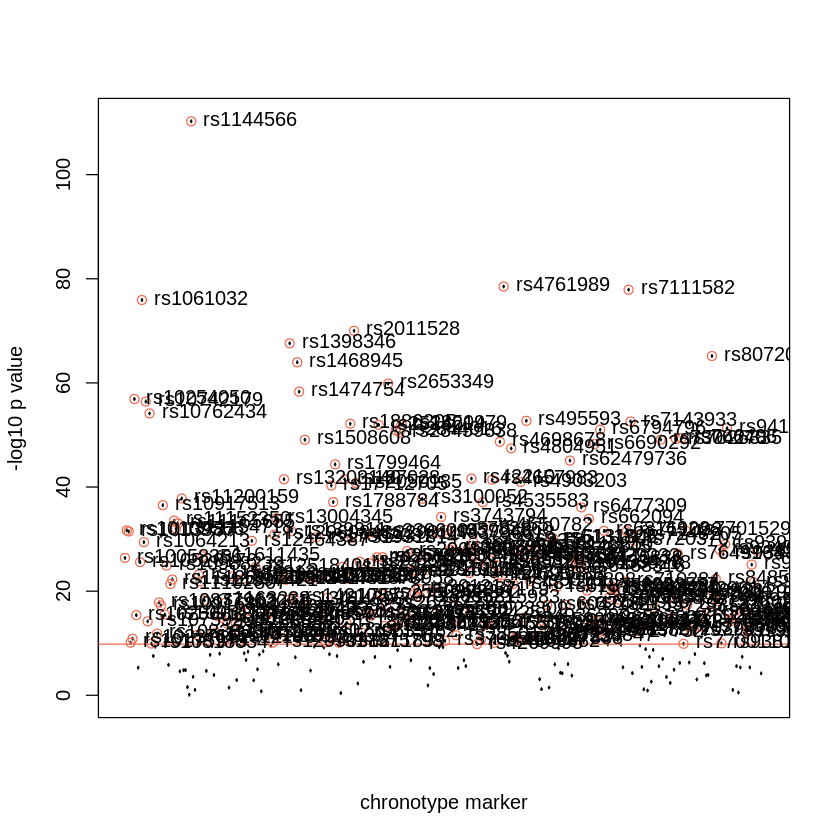

In [56]:
# plot of -log of p value

# calculate the -l0g10 p value for plotting
y <- -log10(results$p.value)

## make a plot of the -log10 p vale
plot(as.factor(results$group), y, type = "p", xaxt='n', xlab = "chronotype marker", ylab = "-log10 p value")
# this threshold is set for multiple hypothesis testing for all the variants in the genome - change as appropriate
threshold <- y > -log10(0.05/324000000)
## add a line for the threhold for clarity
abline(h = -log10(0.05/324000000), col = 'coral2', lwd = 1)
points(as.factor(results$group)[threshold], y[threshold], col="coral2")
text(as.factor(results$group)[threshold], y[threshold], labels = as.factor(results$group)[threshold], pos = 4)


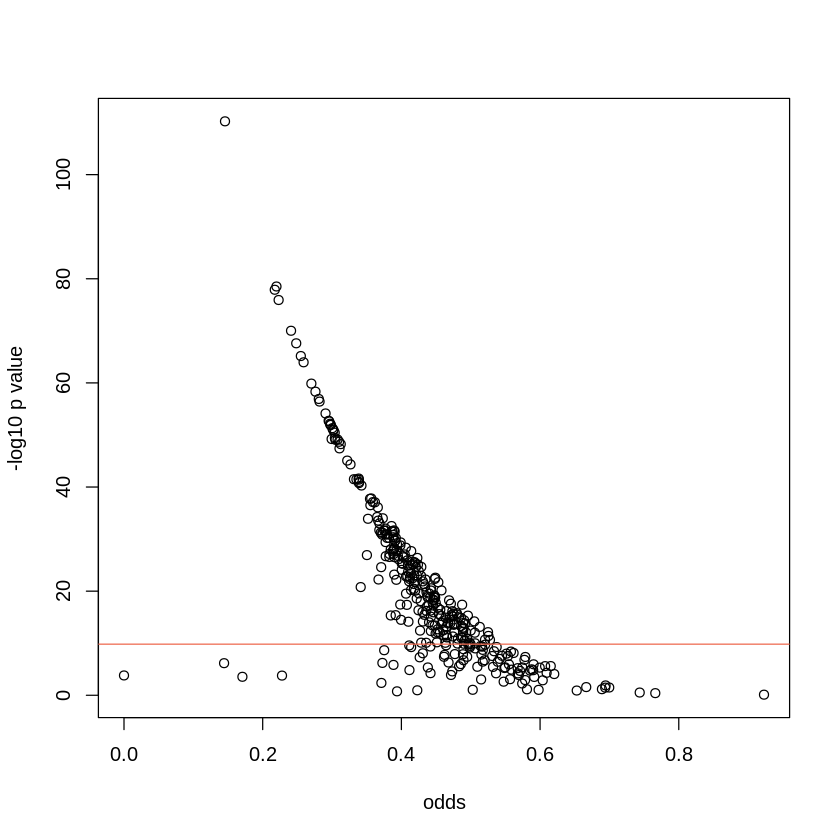

In [61]:
# volcano plot

plot(results$odds, y, type = "p", xlab = "odds", ylab = "-log10 p value")
# this threshold is set for multiple hypothesis testing for all the variants in the genome - change as appropriate
threshold <- y > -log10(0.05/324000000)
## add a line for the threhold for clarity
abline(h = -log10(0.05/324000000), col = 'coral2', lwd = 1)
points(as.factor(results$group)[threshold], y[threshold], col="coral2")
text(as.factor(results$group)[threshold], y[threshold], labels = as.factor(results$group)[threshold], pos = 4)

you now have three simple graphs
note that the p value graph will show both under and over enriched variants, whereas the odds ratio will only show over enriched


# 4. Try to make sense of the data

##Extension task:
A final thing to do would be to add up the number of morning and evening markers present in the dataset and generate a simple 2x2 contingency table for each of the four datasets which compares the presence of morning and evening markers in the two groups. The labels for which markers are morning and evening are in this dataset:

In [ ]:
label <- read.csv(https://www.dropbox.com/s/1cyds7va2cbcefd/morning_evening_label.csv?dl=1)

You will have to merge the labels for morning and evening with your data and then sum all the alleles for morning and evening.